# Import

In [ ]:
import dataclasses
from functools import partial
import torch
import pandas as pd

from transformers import AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import Dataset

from torch.nn import functional as F
from sklearn.metrics import cohen_kappa_score
import numpy as np

# Set up Config

In [ ]:
model_paths = "microsoft/deberta-v3-small"
MAX_RATING = 6

@dataclasses.dataclass
class Config:
    batch_size: int = 4 # per a device
    max_seq_length: int = 1024
    lr: float = 2e-5
    epochs: int = 4
    pad_to_multiple_of: int = 16
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = False

# Define Conditional Ordinal Regression Loss
This loss is introduced in the paper called "[Deep Neural Networks for Rank-Consistent Ordinal Regression Based On Conditional Probabilities](https://arxiv.org/abs/2111.08851)". 

The outline of the loss function is depicted like the image:


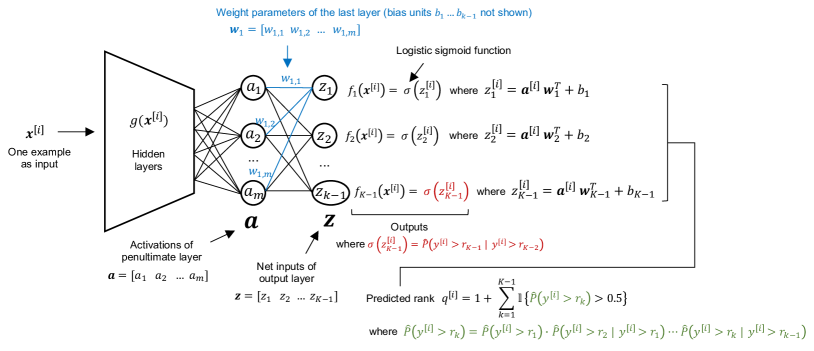 

The loss function is designed for handling ordinal regression tasks. So, I can say that the loss fits the essay scoring task in the comp. I try the loss function.


In [ ]:

class OrdinalRegressionLoss(torch.nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.num_labels = num_labels

    def forward(self, logits, labels):
        sets = []
        for i in range(MAX_RATING - 1):
            label_mask = labels > i - 1 + 1
            label_tensor = (labels[label_mask] > i + 1).to(torch.int64)
            sets.append([label_tensor, label_mask])

        loss = 0
        for i, (label_tensor, label_mask) in enumerate(sets):
            if len(label_tensor) < 1:
                continue
            logit = logits[label_mask, i]
            loss += -torch.sum(
                F.logsigmoid(logit) * label_tensor + (F.logsigmoid(logit) - logit) * (1 - label_tensor)
            )
        loss /= MAX_RATING
        return loss


In [ ]:

class MyTrainer(Trainer):
    def __init__(
        self, **kwargs
    ):
        super().__init__(**kwargs)
        self.loss_func = OrdinalRegressionLoss(num_labels=self.model.config.num_labels)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = self.loss_func
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


# Let's train!

In [ ]:

def tokenize(example, tokenizer, max_length=None):
    tokenized = tokenizer(example["full_text"], padding=False,max_length=max_length, truncation=True)
    return tokenized


def build_dataset(tokenizer, max_seq_length):

    data = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv")
    data["score"] = data["score"].astype(float)
    data = Dataset.from_pandas(data)
    data = data.map(tokenize, batched=True, fn_kwargs={"tokenizer": tokenizer, "max_length": max_seq_length}, remove_columns=["full_text", "essay_id"])
    data = data.rename_column("score", "labels")

    data = data.train_test_split(test_size=0.2)
    train_ds = data["train"]
    val_ds = data["test"]

    return train_ds, val_ds



def compute_metrics(pred):
    predictions, labels = pred

    # predictions: (batch_size, MAX_RATING - 1)
    predictions = 1 / (1 + np.exp(-predictions))
    predictions = np.cumprod(predictions, axis=1)
    predictions = (predictions > 0.5).sum(axis=1) + 1
    predictions = np.clip(predictions, 1, 6)

    metric = cohen_kappa_score(labels, predictions, weights="quadratic", labels=[1, 2, 3, 4, 5, 6])
    return {"kappa": metric}

def run_train():

    config = Config()
    tokenizer = AutoTokenizer.from_pretrained(model_paths)
    model = AutoModelForSequenceClassification.from_pretrained(model_paths, num_labels=MAX_RATING - 1)
    print(model)

    train_ds, val_ds = build_dataset(tokenizer,config.max_seq_length)

    collator = DataCollatorWithPadding(tokenizer, padding="longest", pad_to_multiple_of=config.pad_to_multiple_of )

    args = TrainingArguments(
        output_dir="output/",
        fp16=True,
        learning_rate=config.lr,
        num_train_epochs=config.epochs,
        per_device_train_batch_size=config.batch_size,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        report_to="none",
        save_total_limit=1,
        logging_steps=200,
        lr_scheduler_type='linear',
        metric_for_best_model="kappa",
        greater_is_better=True,
        warmup_ratio=0.0,
        weight_decay=0.01,
        load_best_model_at_end=True,
        save_strategy="steps",
        save_steps=500,
        evaluation_strategy="steps",
        eval_steps=500,
        per_device_eval_batch_size=8,
        fp16_full_eval=True,
        gradient_checkpointing=config.gradient_checkpointing,
    )

    trainer = MyTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    trainer.train()
    trainer.save_model("output/final_model")
    tokenizer.save_pretrained("output/final_model")



In [ ]:
run_train()